# Продвинутые A/B тесты. Домашнее задание


### Задание



[Файл](https://s3-us-west-2.amazonaws.com/secure.notion-static.com/52fed7b1-6b20-4094-ba15-74ffc02e5306/Домашнее_задание_Бизнес-4_(исходник).csv) для работы над заданием


Вы работаете аналитиком в быстрой доставке SkySamokat. Периодически клиентам рассылаются пуш-уведомления, в которых описывается специальное предложение недели. 

Перед вами список клиентов, которые получали эти пуш-уведомления. По результату рассылки они воспользовались или не воспользовались предложением (поле ***flag_conv***).

Ваши коллеги из отдела маркетинга собираются запустить АБ Тест, в рамках которого они собираются проверить, не будет ли смс-сообщение более эффективным чем пуш-уведомление.

К проектированию данного АБ Теста решили привлечь вас. Вам необходимо протестировать систему сплитования и рассчитать время, необходимое для расчета эксперимента.


**Ход решения:**

1. Исследуйте зависимость пользования предложением от идентификатора клиента. Видите ли вы какие-то закономерности?
    - Подсказка
        
        Постройте график зависимости таргет-величины от последней цифры идентификатора клиента. Воспользуйтесь следующим кодом:
        
        `df['right_symbol'] = df['id_client'].astype(str).str[-1]`
        
2. Сделайте разбиение клиентов по группам (контроль и тест) в зависимости от остатка деления идентификатора на 10. Рассчитайте результаты АА-теста. Наблюдается ли разница?
3. Сделайте разбиение клиентов по группам (контроль и тест) в зависимости от четности идентификатора (остатка от деления идентификатора на 2). Рассчитайте результаты АА-теста. Наблюдается ли разница?
4. Сделайте разбиение клиентов по группам (контроль и тест) с помощью функции sample из библиотеки pandas. По аналогии с расчетом из лекции сделайте 1000 разбиений с помощью sample и рассчитайте статистическую значимость разниц. В скольких процентах случаев наблюдается статистически значимая разница между контролем и тестом в АА-тесте?
    
    **Задача со звездочкой**: проверьте, что это доля (случаев, в которых разница между группами есть) равна 5% на 95%-уровне значимости.
     
5. Рассчитайте, сколько наблюдений потребуется для проведения АБ Теста, при условии что MDE = 2 процентных пункта (предположите, что альфа и бета установлены на дефолтном уровне и что дисперсия выборки не изменится от воздействия В).


***П.с.:*** Заимствуйте код из предыдущих заданий, это поможет решать задачу быстрее.


---
#### Импорт необходимых библиотек и исходных данных

In [1]:
# libs
import pandas as pd
import numpy as np
from scipy import stats

from matplotlib import pyplot as plt
import seaborn as sns

from binascii import crc32

In [2]:
# dats
f_name = 'Домашнее задание Бизнес-4 (исходник).csv'
data = pd.read_csv(f_name, sep=';')
data.head(5)

,id_client,flag_conv
0,1345321,0
1,1345322,0
2,1345330,0
3,1345338,1
4,1345342,0


### Решение:

***1. Исследуйте зависимость пользования предложением от идентификатора клиента. Видите ли вы какие-то закономерности?***
    - Подсказка
        
        Постройте график зависимости таргет-величины от последней цифры идентификатора клиента.  
        Воспользуйтесь следующим кодом:
        
        `df['right_symbol'] = df['id_client'].astype(str).str[-1]`

In [3]:
data['right_symbol'] = data['id_client'].astype(str).str[-1]
data.sample(10).sort_values(by='right_symbol')
# Визуально зависимость не очевидна... Попробую сгрупировать

,id_client,flag_conv,right_symbol
2652,1358470,1,0
1160,1350973,0,3
126,1345943,0,3
2373,1357056,0,6
1392,1352117,1,7
653,1348498,1,8
216,1346388,0,8
2720,1358818,0,8
1942,1354859,1,9
2491,1357629,1,9


In [4]:
data_gb = data.groupby('right_symbol').agg(mean_conv = ('flag_conv', 'mean'),
                                           cnt_conv = ('flag_conv', 'count')).reset_index()
data_gb

,right_symbol,mean_conv,cnt_conv
0,0,0.996835,316
1,1,0.603715,323
2,2,0.543689,309
3,3,0.543624,298
4,4,0.528662,314
5,5,0.545732,328
6,6,0.529412,340
7,7,0.632258,310
8,8,0.563518,307
9,9,0.632716,324


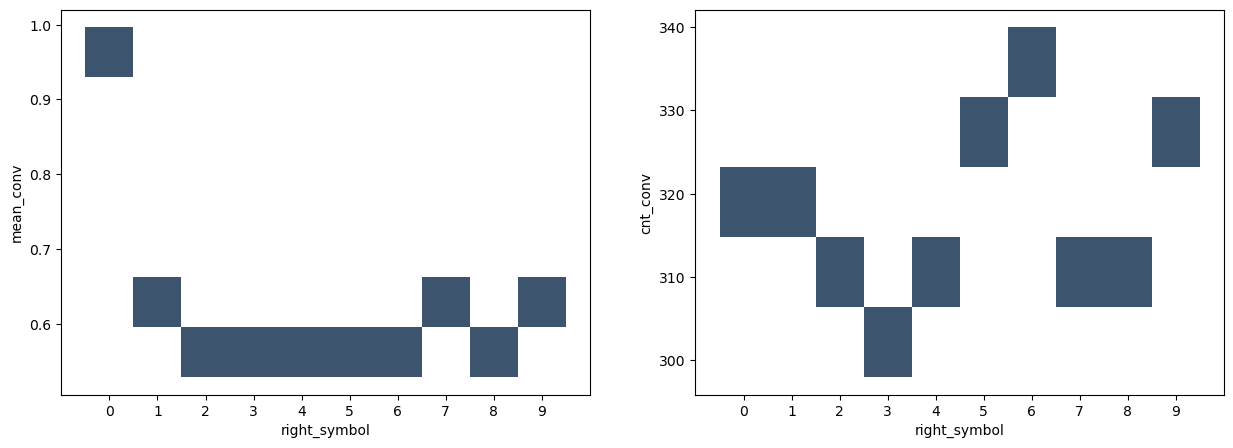

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.histplot(ax=ax[0], data=data_gb, x='right_symbol', y='mean_conv')
sns.histplot(ax=ax[1], data=data_gb, x='right_symbol', y='cnt_conv')
plt.show()

# По гистограммам очевидно что клиенты, 
# id которых оканчиваются на 0, почти всегда (с вероятностью в 0.996) воспользуются предложением.

***2. Сделайте разбиение клиентов по группам (контроль и тест) в зависимости от остатка деления идентификатора на 10. Рассчитайте результаты АА-теста. Наблюдается ли разница?***

Из гисторграммы видно что для разбиения на группы (тестовую и контрольную) придется хешировать id.

In [6]:
# Наверно можно было сделать проще.....!
data['hash_id'] = data['id_client'].map(lambda x: crc32(bytes(str(x), 'utf-8')))
data['salz_id'] = data['id_client'].map(lambda x: crc32(bytes(str(x) + 'соль', 'utf-8')))
data.head()

,id_client,flag_conv,right_symbol,hash_id,salz_id
0,1345321,0,1,406920652,282843958
1,1345322,0,2,2168999030,693561331
2,1345330,0,0,1985813531,3898778699
3,1345338,1,8,2022085673,1404700243
4,1345342,0,2,3608341488,608737204


In [7]:
# функцию взял из своего решения прошлого ДЗ (в задании рекомендовано)
def get_result_ABtest(test_df: pd.DataFrame, control_df: pd.DataFrame) -> None:
    '''Выводит на печать результат А/В тестирования.'''
    s, p = stats.ttest_ind(control_df, test_df)
    print('\tp_value', round(p, 4))
    if (p > 0.05):
        print('+       Выборки не имеют существенной разницы!')
    else:
        print('-       РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ:')
        if control_df.mean() > test_df.mean():
            diff = ((control_df.mean() - test_df.mean()) / control_df.mean()) * 100
            print(f'\tСредняя выборки тестовой группы к контрольной УПАЛА на {round(diff, 2)}%!')
        elif control_df.mean() < test_df.mean():
            diff = ((test_df.mean() - control_df.mean()) / control_df.mean()) * 100
            print(f'\tСредняя выборки тестовой группы к контрольной ВЫРОСЛА на {round(diff, 2)}%!')
    print()

Ищу способ наиболее эффективного разделения выборок с равным распределением

In [8]:
print('Разбиение клиентов по группам в зависимости от остатка деления идентификатора на 10.\n')
# -------------------------------------------------- Разделим на выборки по последней цифре id_client
print('_ ' * 50, '\nГруппы разделенные по последней цифре id_cleent')
df_testAA = data[['id_client', 'flag_conv']]

part_50 = df_testAA[df_testAA['id_client'] % 10 < 5]
rest_part_50 = df_testAA.drop(part_50.index)

get_result_ABtest(part_50['flag_conv'], rest_part_50['flag_conv']) 

# -------------------------------------------------- Разделим на выборки по последней цифре хешированного значения id_client
print('_ ' * 50, '\nГруппы разделенные по последней цифре хеш-значения id_cleent')
df_testAA = data[['hash_id', 'flag_conv']]

part_50 = df_testAA[df_testAA['hash_id'] % 10 < 5]
rest_part_50 = df_testAA.drop(part_50.index)

get_result_ABtest(part_50['flag_conv'], rest_part_50['flag_conv'])

# -------------------------------------------------- Разделим на выборки по последней цифре хешир.значения id_client (подсолено)
print('_ ' * 50, '\nГруппы разделенные по последней цифре "подсоленного" хеш-значения id_cleent')
df_testAA = data[['salz_id', 'flag_conv']]

part_50 = df_testAA[df_testAA['salz_id'] % 10 < 5]
rest_part_50 = df_testAA.drop(part_50.index)

get_result_ABtest(part_50['flag_conv'], rest_part_50['flag_conv'])
 

Разбиение клиентов по группам в зависимости от остатка деления идентификатора на 10.

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _  
Группы разделенные по последней цифре id_cleent
	p_value 0.0002
-       РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ:
	Средняя выборки тестовой группы по сравнению с контрольной ВЫРОСЛА на 11.21%!

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _  
Группы разделенные по последней цифре хеш-значения id_cleent
	p_value 0.0024
-       РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ:
	Средняя выборки тестовой группы по сравнению с контрольной ВЫРОСЛА на 8.98%!

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _  
Группы разделенные по последней цифре "подсоленного" хеш-значения id_cleent
	p_value 0.1816
+       Выборки не имеют существенной разницы!
	Изменения над тестовой группой не повлеяли на качественные показатели
	по отношению к контрольной груп

**Вывод:**  
для правильного разделения выборки на две подгруппы в зависимости от остатка деления идентификатора на 10, можно использовать через "подсоленое" хеширование идентефикаторов (иной подход не дал "равнораспределенности" группы)

***3. Сделайте разбиение клиентов по группам (контроль и тест) в зависимости от четности идентификатора (остатка от деления идентификатора на 2). Рассчитайте результаты АА-теста. Наблюдается ли разница?***

In [9]:
print('Разбиение клиентов по группам в зависимости от четности идентификатора.\n')
# -------------------------------------------------- Разделим на выборки по последней цифре id_client
print('_ ' * 50, '\nГруппы разделенные по последней цифре id_cleent')
df_testAA = data[['id_client', 'flag_conv']]

part_50 = df_testAA[df_testAA['id_client'] % 2 == 0]
rest_part_50 = df_testAA.drop(part_50.index)

get_result_ABtest(part_50['flag_conv'], rest_part_50['flag_conv']) 

# -------------------------------------------------- Разделим на выборки по последней цифре хешированного значения id_client
print('_ ' * 50, '\nГруппы разделенные по последней цифре хеш-значения id_cleent')
df_testAA = data[['hash_id', 'flag_conv']]

part_50 = df_testAA[df_testAA['hash_id'] % 2 == 0]
rest_part_50 = df_testAA.drop(part_50.index)

get_result_ABtest(part_50['flag_conv'], rest_part_50['flag_conv'])

# -------------------------------------------------- Разделим на выборки по последней цифре хешир.значения id_client (подсолено)
print('_ ' * 50, '\nГруппы разделенные по последней цифре "подсоленного" хеш-значения id_cleent')
df_testAA = data[['salz_id', 'flag_conv']]

part_50 = df_testAA[df_testAA['salz_id'] % 2 == 0]
rest_part_50 = df_testAA.drop(part_50.index)

get_result_ABtest(part_50['flag_conv'], rest_part_50['flag_conv'])


Разбиение клиентов по группам в зависимости от четности идентификатора.

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _  
Группы разделенные по последней цифре id_cleent
	p_value 0.0213
-       РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ:
	Средняя выборки тестовой группы по сравнению с контрольной ВЫРОСЛА на 6.73%!

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _  
Группы разделенные по последней цифре хеш-значения id_cleent
	p_value 0.4836
+       Выборки не имеют существенной разницы!
	Изменения над тестовой группой не повлеяли на качественные показатели
	по отношению к контрольной группуе...

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _  
Группы разделенные по последней цифре "подсоленного" хеш-значения id_cleent
	p_value 0.6548
+       Выборки не имеют существенной разницы!
	Изменения над тестовой группой не повлеяли на качественные показатели


***Вывод:***  
+ для правильного разделения выборки на две подгруппы в зависимости от четности, можно использоватькак простое так и через "подсоленое" хеширование идентефикаторов (иной подход не дал "равнораспределенности" группы)
- простое разделение на группы в зависимости от четности дало отрицательный результат (группы не равнораспределенны)

***4. Сделайте разбиение клиентов по группам (контроль и тест) с помощью функции sample из библиотеки pandas. По аналогии с расчетом из лекции сделайте 1000 разбиений с помощью sample и рассчитайте статистическую значимость разниц. В скольких процентах случаев наблюдается статистически значимая разница между контролем и тестом в АА-тесте?***

**Задача со звездочкой**: проверьте, что это доля (случаев, в которых разница между группами есть) равна 5% на 95%-уровне значимости.

In [10]:
# -------------------------------------------------- Разделим на выборки случайным "семплированием" на равные доли
print('_ ' * 50, '\nГруппы разделенные встроенным методом .sample(frac=0.5)')
df_testAA = data[['id_client', 'flag_conv']]

part_50 = df_testAA.sample(frac = 0.5)
rest_part_50 = df_testAA.drop(part_50.index)

get_result_ABtest(part_50['flag_conv'], rest_part_50['flag_conv']) 

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _  
Группы разделенные встроенным методом .sample(frac=0.5)
	p_value 0.2206
+       Выборки не имеют существенной разницы!
	Изменения над тестовой группой не повлеяли на качественные показатели
	по отношению к контрольной группуе...



***Проверим повторяемость результата на 1000 попыток***

In [11]:
df_testAA = data[['id_client', 'flag_conv']]
df_res = pd.DataFrame(columns=['iter','stat_crit','p_value'])

for i in range(1,1000):
    part_50 = df_testAA.sample(frac = 0.5)
    rest_part_50 = df_testAA.drop(part_50.index)

    s_a, p_a = stats.ttest_ind(part_50['flag_conv'], rest_part_50['flag_conv'])
    
    df_res = df_res._append({'iter':i,'stat_crit':s_a,'p_value':p_a}, ignore_index = True) 

In [12]:
print('Проверяю, что доля случаев, в которых разница между группами есть, равна 5% на 95%-уровне значимости:')
df_res[df_res['p_value']<=0.05].count() /df_res.count()

Проверяю, что доля случаев, в которых разница между группами есть, равна 5% на 95%-уровне значимости:


iter         0.048048
stat_crit    0.048048
p_value      0.048048
dtype: float64

***Вывод:***  
по результатам 1000 тестов, около 5% попыток не удовлетворили условию - считаю что ТЕСТ ПРОЙДЕН

***5. Рассчитайте, сколько наблюдений потребуется для проведения АБ Теста, при условии что MDE = 2 процентных пункта (предположите, что альфа и бета установлены на дефолтном уровне и что дисперсия выборки не изменится от воздействия В).***


Количество наблюдений посчитаем по упращенной формуле:

\begin{align}
n  =  \frac{16 \dot \sigma^2}{MDE^2}, где:
\end{align}

$n$ - количество наблюдений,  
$\sigma^2$ - дисперсия,  
$MDE$ - минимальная обнаруживаемая разница

In [13]:
mde = 0.02
var = np.var(data['flag_conv'])
nms = (16 * var) / (mde**2)

print(f'Расчитанное количество необходимых наблюдений для А/В теста = {round(nms)}')

Расчитанное количество необходимых наблюдений для А/В теста = 9499
